Analysing USA economic indices

Imports...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import eurostat
from sklearn.preprocessing import MinMaxScaler
import pycountry
from sklearn.preprocessing import StandardScaler
import time

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key="2e41dcd553b1b84b0321e2e5cc4929d3"



Creating FRED object

In [2]:
fred=Fred(api_key=fred_key)

Searching for GDP databases

In [3]:
results = fred.search('USA,  GDP',order_by="popularity")
results.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
GDP,GDP,2023-05-14,2023-05-14,Gross Domestic Product,1947-01-01,2023-01-01,Quarterly,Q,Billions of Dollars,Bil. of $,Seasonally Adjusted Annual Rate,SAAR,2023-04-27 07:53:02-05:00,93,BEA Account Code: A191RC Gross domestic produ...
GDPC1,GDPC1,2023-05-14,2023-05-14,Real Gross Domestic Product,1947-01-01,2023-01-01,Quarterly,Q,Billions of Chained 2012 Dollars,Bil. of Chn. 2012 $,Seasonally Adjusted Annual Rate,SAAR,2023-04-27 07:53:02-05:00,91,BEA Account Code: A191RX Real gross domestic ...
GFDEGDQ188S,GFDEGDQ188S,2023-05-14,2023-05-14,Federal Debt: Total Public Debt as Percent of ...,1966-01-01,2022-10-01,Quarterly,Q,Percent of GDP,% of GDP,Seasonally Adjusted,SA,2023-03-30 08:05:01-05:00,84,Federal Debt: Total Public Debt as Percent of ...
M2V,M2V,2023-05-14,2023-05-14,Velocity of M2 Money Stock,1959-01-01,2023-01-01,Quarterly,Q,Ratio,Ratio,Seasonally Adjusted,SA,2023-04-27 07:59:01-05:00,83,Calculated as the ratio of quarterly nominal G...
PAYEMS,PAYEMS,2023-05-14,2023-05-14,"All Employees, Total Nonfarm",1939-01-01,2023-04-01,Monthly,M,Thousands of Persons,Thous. of Persons,Seasonally Adjusted,SA,2023-05-05 07:45:01-05:00,83,"All Employees: Total Nonfarm, commonly known a..."


Ploting GDP for USA

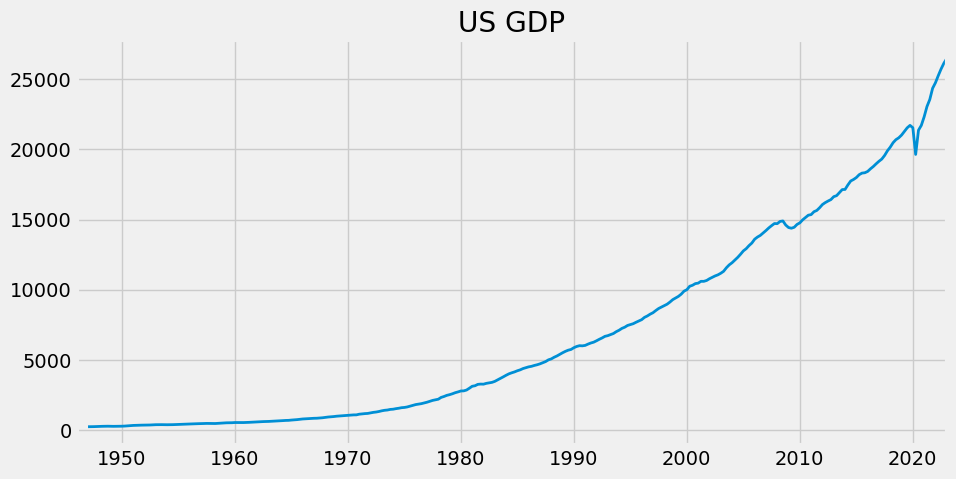

In [4]:
GDP_USA=fred.get_series(series_id='GDP')
GDP_USA.plot(figsize=(10,5),title='US GDP', lw=2)
GDP_USA.dropna()
plt.show()

Adding unemployment rate, inflation and national debt

In [5]:
unemp_df= fred.search('unemployment rate', filter=('frequency','Monthly'))
inflation_df= fred.search('consumer prices for the United States ')
national_debt_df=fred.search("national debt")
inflation_USA=fred.get_series('FPCPITOTLZGUSA')
unemp_USA=fred.get_series('UNRATE')
national_debt_USA=fred.get_series('GFDEGDQ188S')

Scaled ploting

In [6]:
USA = pd.DataFrame({
    'Date': unemp_USA.index,
    'Unemployment Rate': unemp_USA,
    'Inflation Rate': inflation_USA.reindex(unemp_USA.index, method='ffill'),
    'GDP': GDP_USA.reindex(unemp_USA.index, method='ffill'),
    'nat_DEBT': national_debt_USA.reindex(unemp_USA.index, method='ffill')
})

USA = USA[USA['Date'].dt.year >= 1960]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(USA[['Unemployment Rate', 'Inflation Rate', 'GDP','nat_DEBT']])
USA['Unemployment Rate Scaled'] = scaled_data[:, 0]
USA['Inflation Rate Scaled'] = scaled_data[:, 1]
USA['GDP Scaled'] = scaled_data[:, 2]
USA['Nat DEBT Scaled']=scaled_data[:,3]

colors = ['red', 'green', 'blue', 'orange']
fig = px.line(USA, x='Date', y=['GDP Scaled', 'Unemployment Rate Scaled', 'Inflation Rate Scaled','Nat DEBT Scaled'], title='Economic Indicators USA',
              color_discrete_sequence=colors)

fig.update_layout(width=1500, height=600)

fig.show()

In [112]:
national_debt_USA

1966-01-01     40.33999
1966-04-01     39.26763
1966-07-01     39.62091
1966-10-01     39.51977
1967-01-01     39.20383
                ...    
2021-10-01    121.63566
2022-01-01    122.87943
2022-04-01    121.07100
2022-07-01    120.23396
2022-10-01    120.20697
Length: 228, dtype: float64

Now extracting data from eurostat


In [7]:
inflation_indicator = 'prc_hicp_midx'
debt_indicator = 'GOV_10DD_EDPT1'
gdp_indicator = 'nama_10_gdp'
unemployment_indicator = 'une_rt_m'
inflation_data = eurostat.get_data_df(inflation_indicator)
debt_data=eurostat.get_data_df(debt_indicator)
gdp_data = eurostat.get_data_df(gdp_indicator)
unemployment_data = eurostat.get_data_df(unemployment_indicator)

Preparing to Map country names

In [8]:
countries = list(pycountry.countries)
country_mapping = {country.alpha_2: country.name for country in countries}

Cleaning and transforming inflation_data

In [9]:
inflation_data = inflation_data[inflation_data['coicop'] == 'CP00']
inflation_data=inflation_data[inflation_data['unit']== 'I15']
inflation_data.drop(columns=['freq', 'unit', 'coicop'], inplace=True)
inflation_data.rename(columns={'geo\\TIME_PERIOD': 'Country'}, inplace=True)
inflation_data.reset_index(drop=True, inplace=True)


inflation_data_EU=inflation_data['Country'].map(country_mapping)
inflation_data_EU
inflation_data['Country'] = inflation_data_EU
inflation_data.dropna(subset ='Country',inplace= True)
inflation_data

,Country,1996-01,1996-02,1996-03,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04
0,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,101.00,102.28,102.80,102.31,100.90,100.22,100.31,101.30,101.67,101.38,101.44,102.49,105.00,106.09,106.71,106.01,104.32,103.96,103.27,103.88,104.37,104.61,103.91,104.96,106.79,107.81,108.16,107.78,106.22,106.14,105.66,106.02,106.34,105.91,105.41,106.87,109.36,110.25,109.75,109.47,107.98,107.76,107.28,107.61,107.84,107.59,107.35,108.42,111.11,111.77,112.63,112.00,110.98,110.17,109.59,109.83,11

In [20]:
unemployment_data

,freq,s_adj,age,unit,sex,geo\TIME_PERIOD,1983-01,1983-02,1983-03,1983-04,1983-05,1983-06,1983-07,1983-08,1983-09,1983-10,1983-11,1983-12,1984-01,1984-02,1984-03,1984-04,1984-05,1984-06,1984-07,1984-08,1984-09,1984-10,1984-11,1984-12,1985-01,1985-02,1985-03,1985-04,1985-05,1985-06,1985-07,1985-08,1985-09,1985-10,1985-11,1985-12,1986-01,1986-02,1986-03,1986-04,1986-05,1986-06,1986-07,1986-08,1986-09,1986-10,1986-11,1986-12,1987-01,1987-02,1987-03,1987-04,1987-05,1987-06,1987-07,1987-08,1987-09,1987-10,1987-11,1987-12,1988-01,1988-02,1988-03,1988-04,1988-05,1988-06,1988-07,1988-08,1988-09,1988-10,1988-11,1988-12,1989-01,1989-02,1989-03,1989-04,1989-05,1989-06,1989-07,1989-08,1989-09,1989-10,1989-11,1989-12,1990-01,1990-02,1990-03,1990-04,1990-05,1990-06,1990-07,1990-08,1990-09,1990-10,1990-11,1990-12,1991-01,1991-02,1991-03,1991-04,1991-05,1991-06,1991-07,1991-08,1991-09,1991-10,1991-11,1991-12,1992-01,1992-02,1992-03,1992-04,1992-05,1992-06,1992-07,1992-08,1992-09,1992-10,1992-11,1992-12,1993-01,1993-02,1993-03,1993-04,1993-05,1993-06,1993-07,1993-08,1993-09,1993-10,1993-11,1993-12,1994-01,1994-02,1994-03,1994-04,1994-05,1994-06,1994-07,1994-08,1994-09,1994-10,1994-11,1994-12,1995-01,1995-02,1995-03,1995-04,1995-05,1995-06,1995-07,1995-08,1995-09,1995-10,1995-11,1995-12,1996-01,1996-02,1996-03,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04
0,M,NSA,TOTAL,PC_ACT,F,AT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [19]:
#TODO